## GlADE+ catalog visualization

In this notebook, we use the `healpy` library to visualize the data output from the `parse_catalog` script. We follow the tutorial provided in the [`healpy` documentation](https://healpy.readthedocs.io/en/latest/tutorial.html).

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import healpy as hp

from catalog.utils import GalaxyCatalog, Skymap

In [13]:
# Notebook settings
save_figures = False

In [14]:
# Constants
nside = 32
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 32 is 1.8 deg


Number of pixels in the map:

In [15]:
npix = hp.nside2npix(nside)
npix

12288

Importing file:

In [16]:
catalog_path = '/Volumes/binadohd/phd/GLADE+/parsed_catalog.hdf5'
#catalog_path = '../data/GLADE+trimmed_parsed.hdf5'
catalog = GalaxyCatalog(catalog_path)

The `skymap` dataset holds the corresponding pixel for each galaxy. In the cell below, we convert this information into an array of length `npix` holding the number of galaxies within each pixel:

21882387 21882387


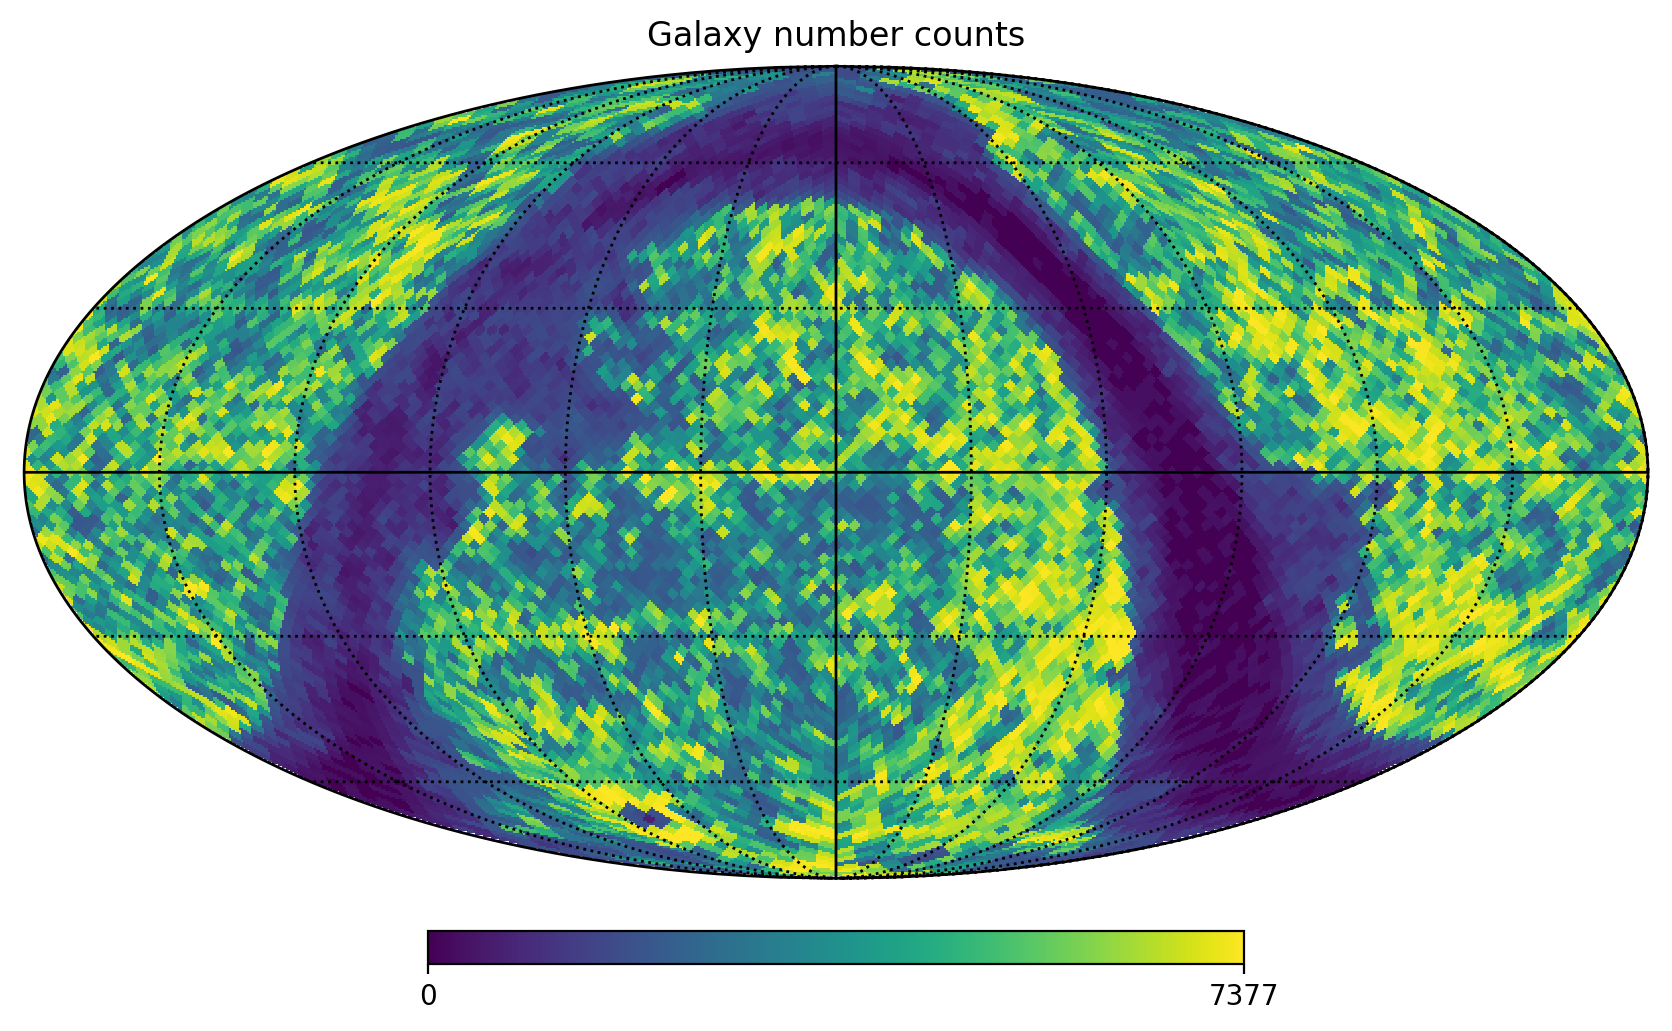

In [17]:
ra, dec = catalog.get('ra'), catalog.get('dec')
print(len(ra), len(dec))
skymap = Skymap(nside, ra, dec, nest=False)
number_density = skymap.counts()
hp.mollview(number_density, title="Galaxy number counts", norm="hist")
hp.graticule()
if save_figures:
    plt.savefig('figures/galaxy-map.png', dpi=400)
plt.show()

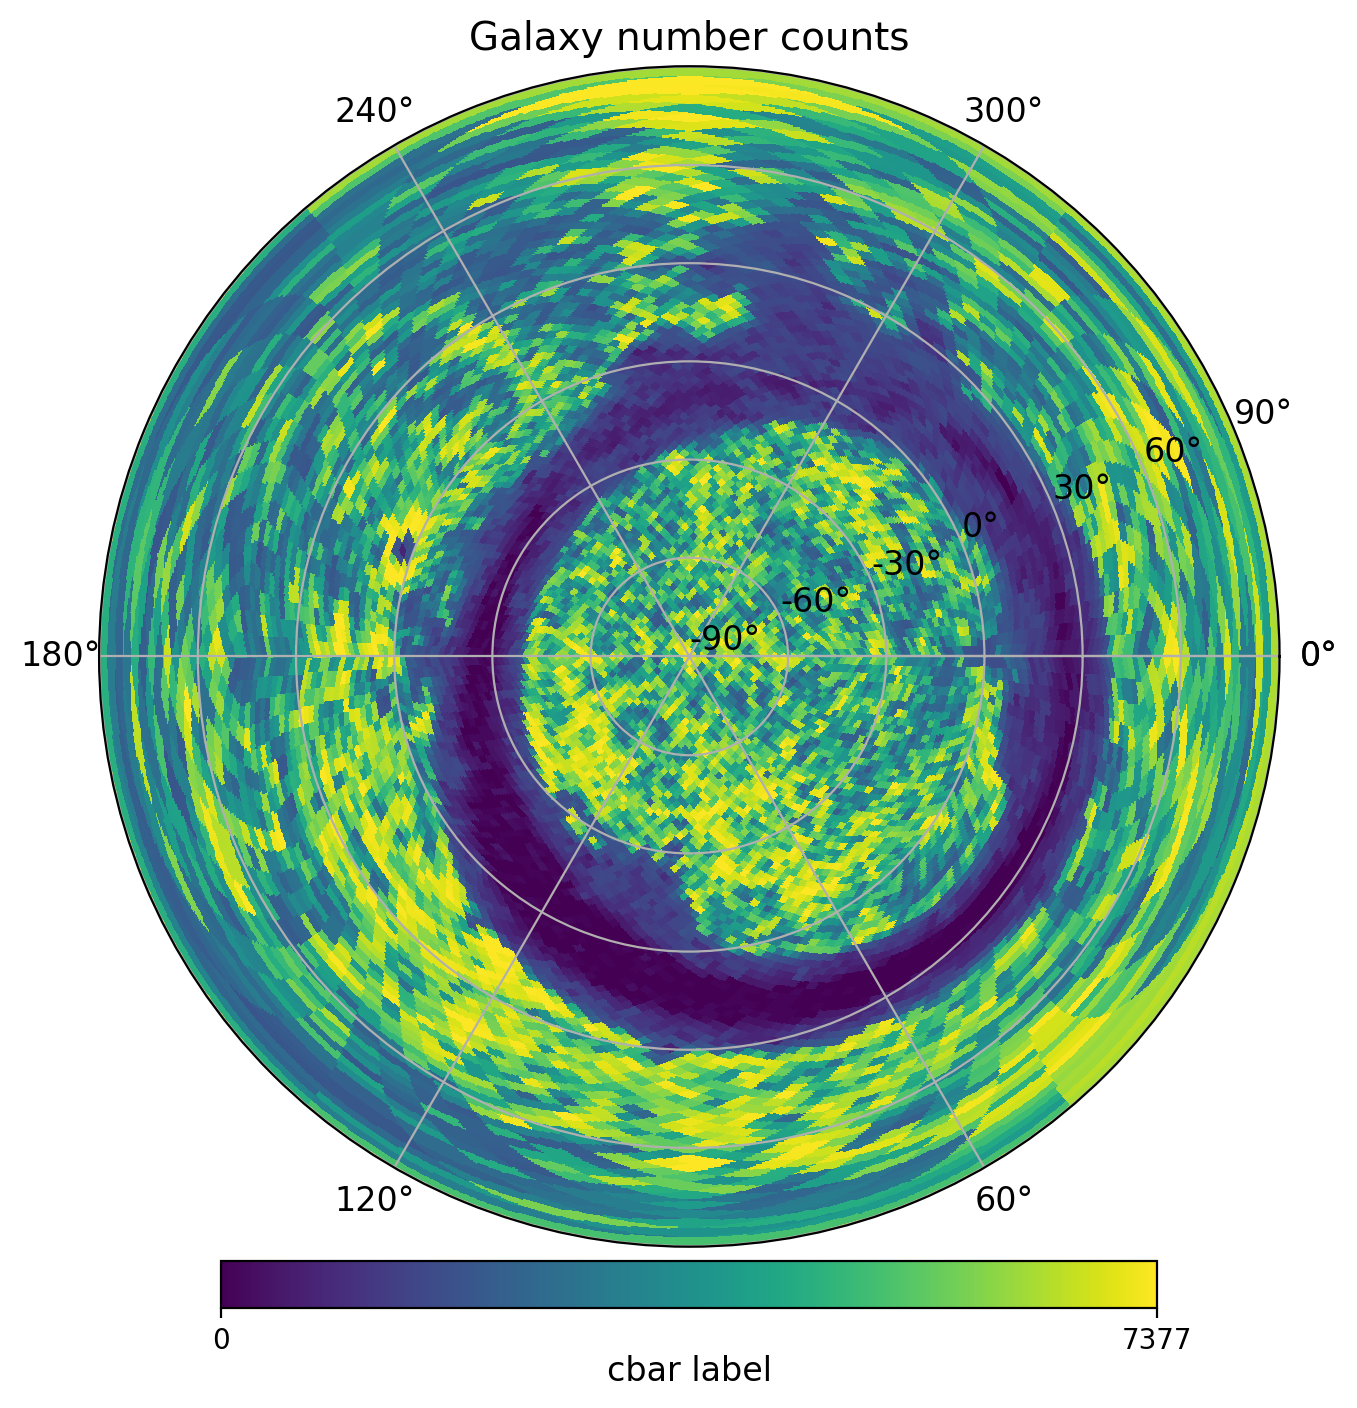

In [18]:
# polar view
hp.projview(
    number_density,
    coord=["G"],
    rot=[0, 90, 180],
    graticule=True,
    graticule_labels=True,
    unit="cbar label",
    norm="hist",
    cb_orientation="horizontal",
    projection_type="polar",
    title="Galaxy number counts",
)
plt.tight_layout()
plt.show()

Histogram of the redshift distribution:

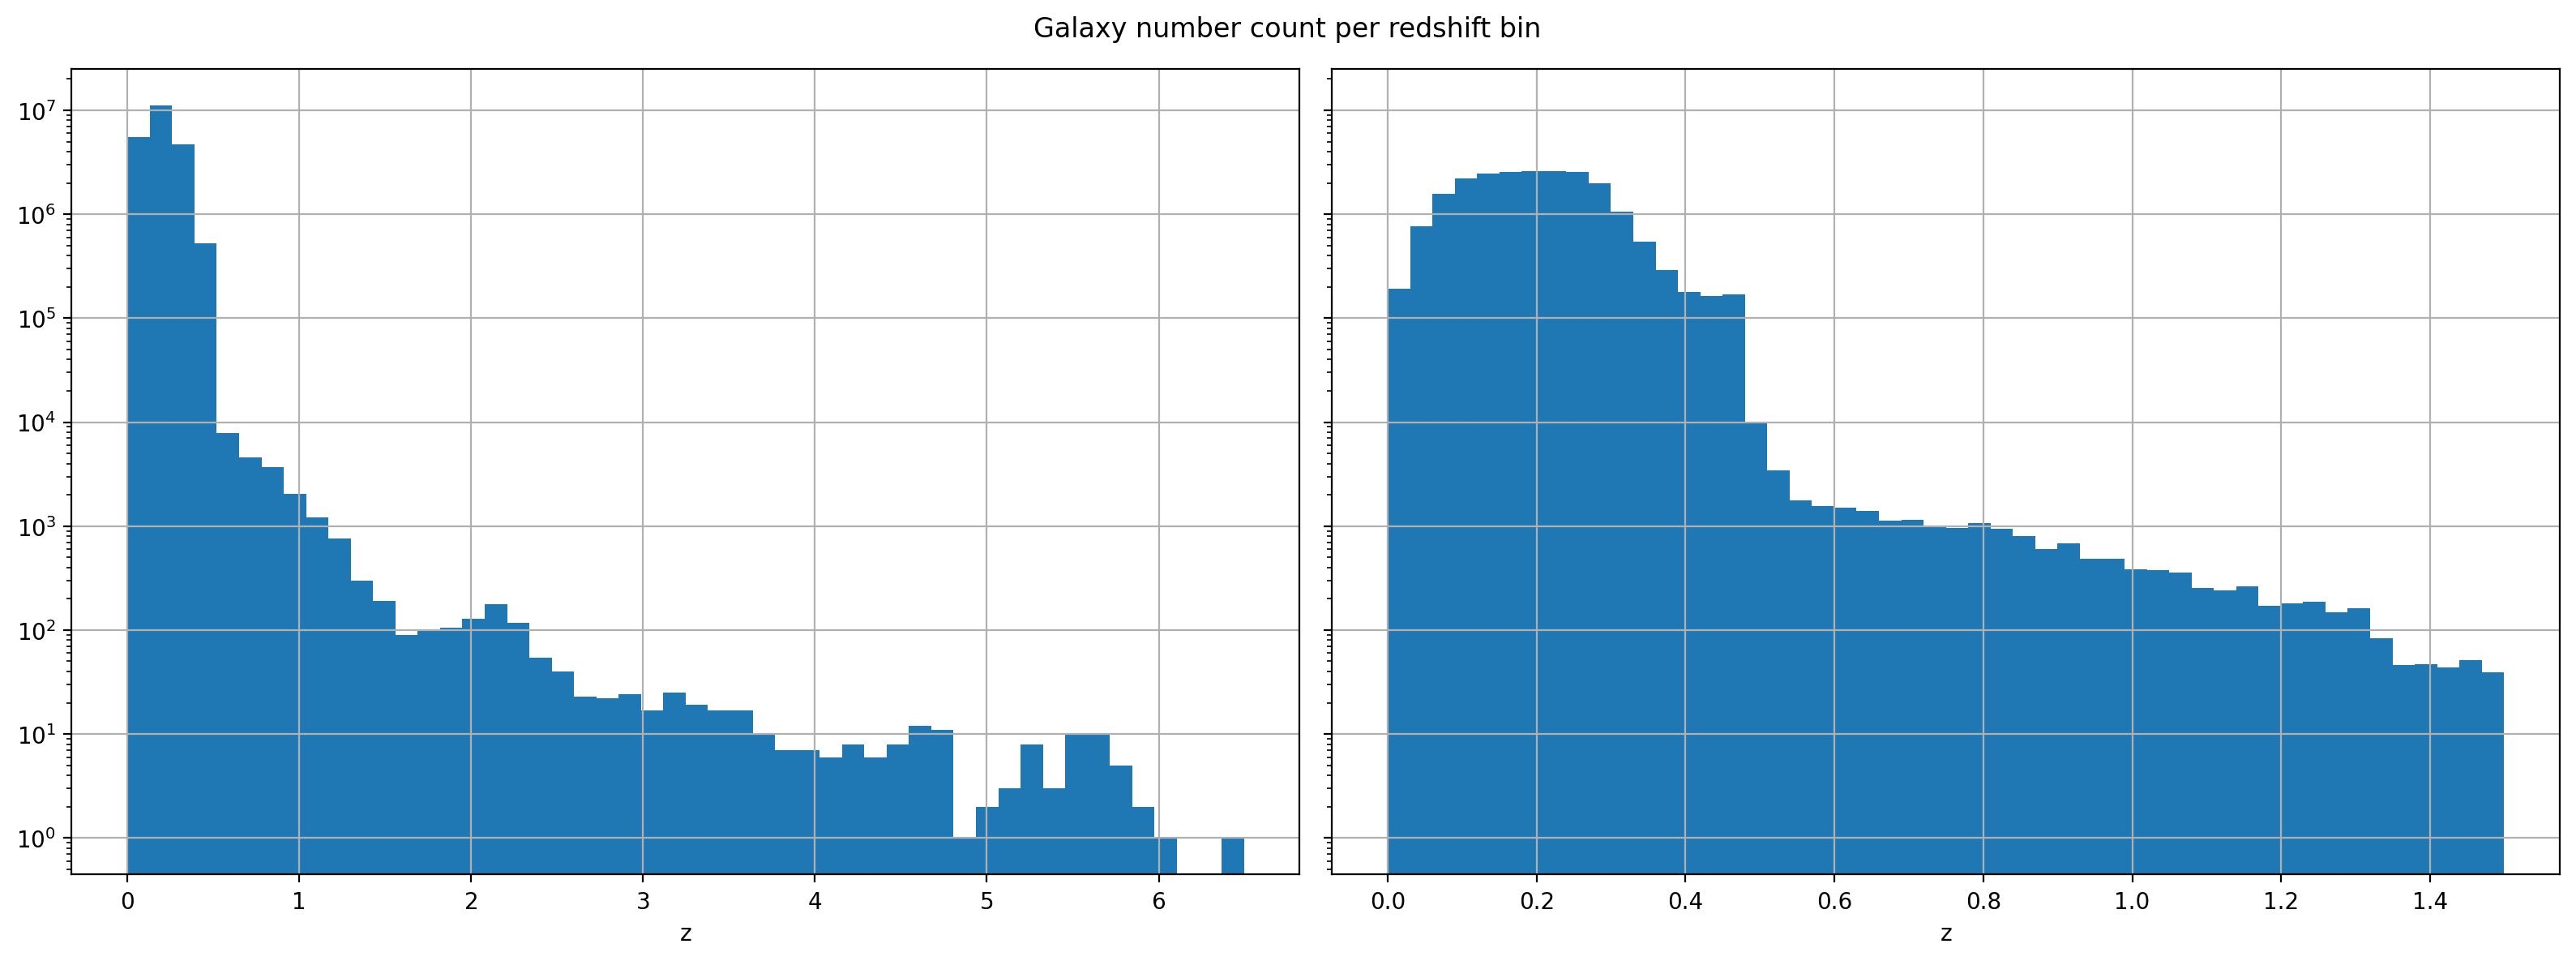

In [19]:
z = catalog.get('z_cmb')
z_max = 1.5
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
ax1.hist(z, bins=50, log=True)
ax2.hist(z[z < z_max], bins=50, log=True)
ax1.set_xlabel('z')
ax2.set_xlabel('z')
ax1.grid()
ax2.grid()
fig.suptitle('Galaxy number count per redshift bin')
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.tight_layout()
if save_figures:
    fig.savefig('figures/galaxy-redshift-distribution.png', dpi=400)
plt.show()

Mergers within galaxies at $z > 1.5$ are very unlikely to be detected by current-generation detectors. Let us repeat the plot upt to $z_{\text{max}}=1.5$:

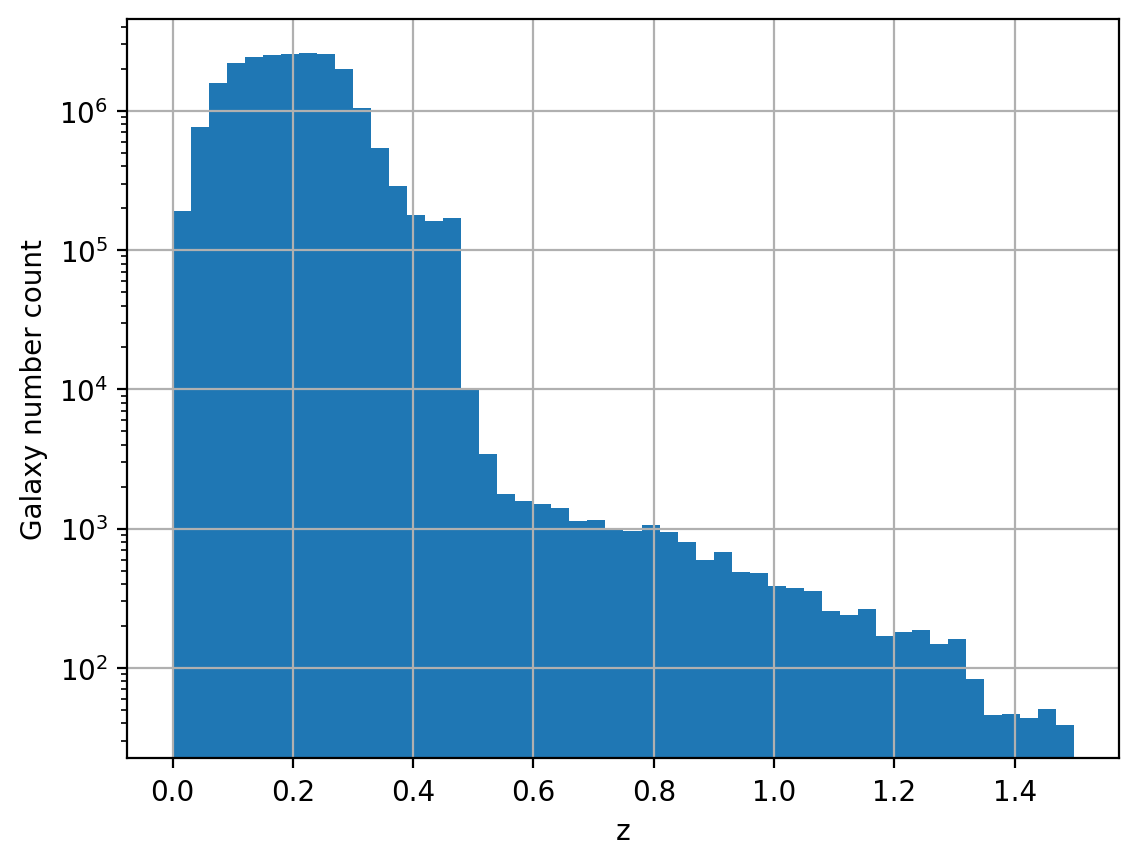

In [20]:
z = catalog.get('z_cmb')
plt.hist(z[z < 1.5], bins=50, log=True)
plt.xlabel('z')
plt.ylabel('Galaxy number count')
plt.grid()
plt.show()

In [24]:
z_bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
nbins = len(z_bins)
masks = skymap.bin_array(z, z_bins)
ra_per_bin  = [skymap.remove_mask(ra, ~mask) for mask in masks]
dec_per_bin  = [skymap.remove_mask(dec, ~mask) for mask in masks]
print([len(ra_per_bin[i]) for i in range(len(z_bins))])

[11429679, 9976901, 459452, 7838, 4469, 4048]


Below we plot the angular power spectrum for each redshift bin. We compute the $c_\ell$ using the HEALPIX `anafast` function after removing the monopole and dipole for stability. For each redshift bin, we plot $c_\ell$ and the rescaled $d_\ell = \ell (\ell + 1)c_\ell / 2\pi$. 

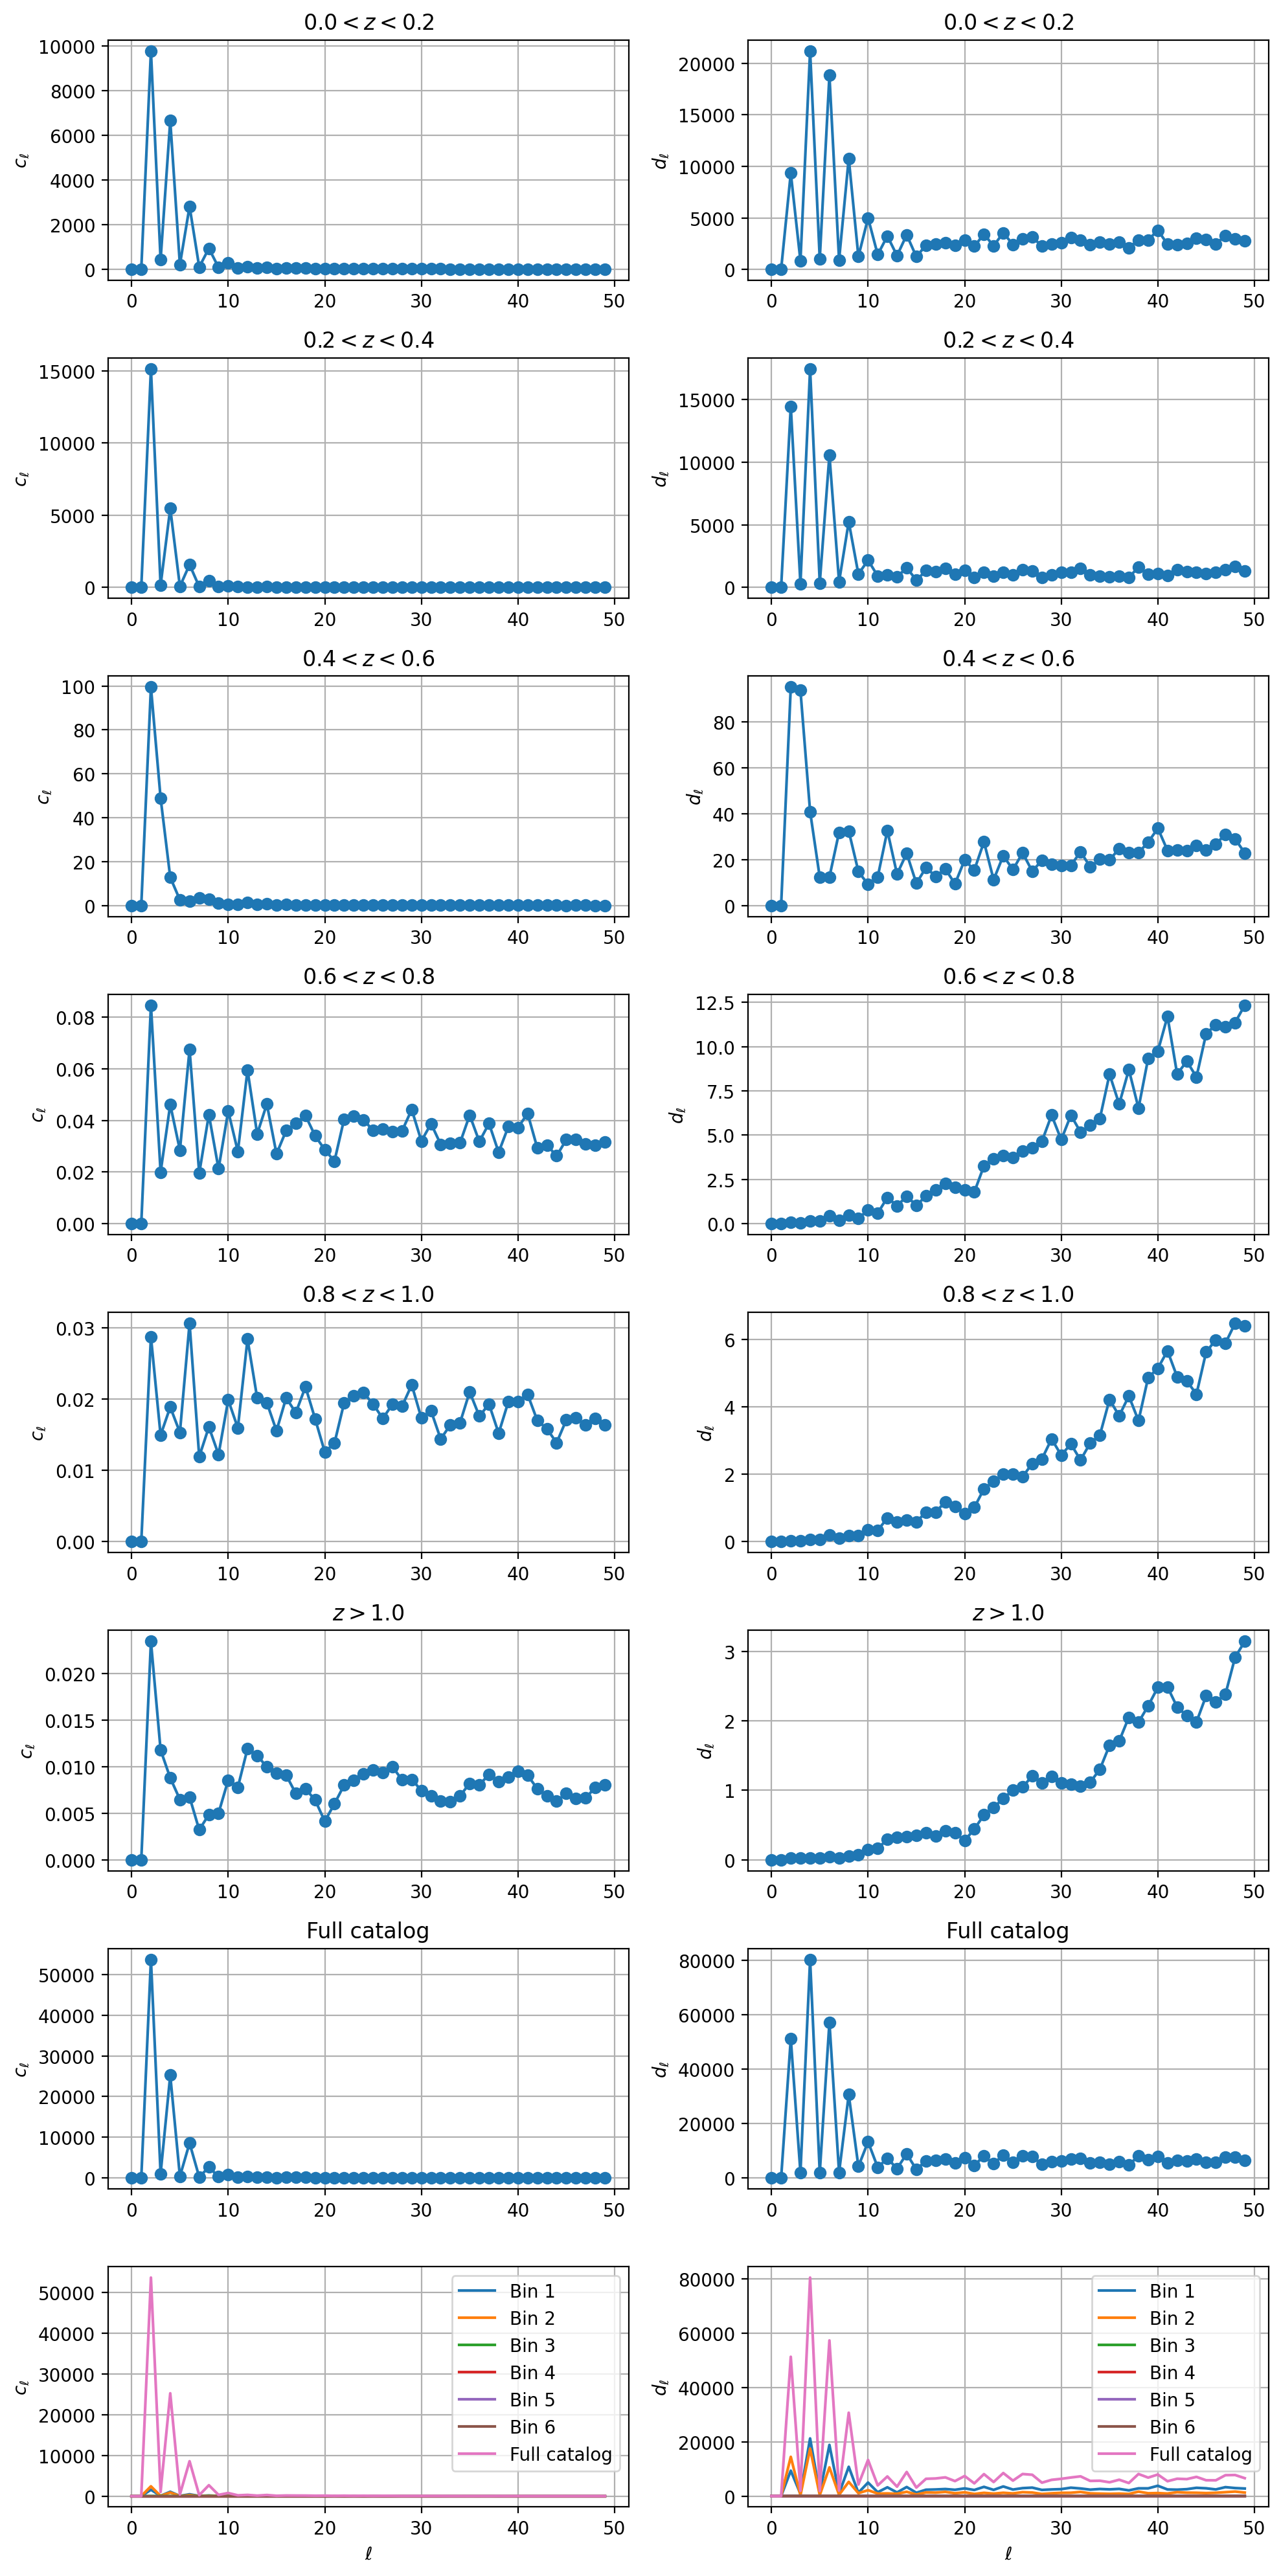

In [42]:
nside = 64
lmax = 3 * nside - 1
ell = np.arange(lmax + 1)
lshow = 50
fig, axs = plt.subplots(nbins + 2, 2, figsize=(10, 3 * nbins + 2))

# Compute angular power spectra for each redshift bin
for i, (rabin, decbin) in enumerate(zip(ra_per_bin, dec_per_bin)):
    bin_skymap = Skymap(nside, rabin, decbin, nest=False)
    map = bin_skymap.counts()
    map = hp.remove_dipole(np.array(map, dtype=np.float64))
    cls = hp.anafast(map, lmax=lmax)

    # Plotting cl and dl
    axs[-1][0].plot(ell[:lshow], cls[:lshow] / (2 * np.pi), label=f'Bin {i + 1}')
    axs[-1][1].plot(ell[:lshow], (ell * (ell + 1) * cls)[:lshow] / (2 * np.pi), label=f'Bin {i + 1}')
    axs[i][0].plot(ell[:lshow], cls[:lshow], '-o')
    axs[i][1].plot(ell[:lshow], (ell * (ell + 1) * cls)[:lshow] / (2 * np.pi), '-o')
    title = r'${} < z < {}$'.format(z_bins[i], z_bins[i + 1]) if i < nbins - 1 else r'$z > {}$'.format(z_bins[i])
    axs[i][0].set_title(title)
    axs[i][1].set_title(title)

# Compute angular power spectra for the full catalog
map = Skymap(nside, ra, dec, nest=False).counts()
map = hp.remove_dipole(np.array(map, dtype=np.float64))
cls = hp.anafast(map, lmax=lmax)
axs[-2][0].plot(ell[:lshow], cls[:lshow], '-o')
axs[-2][1].plot(ell[:lshow], (ell * (ell + 1) * cls)[:lshow] / (2 * np.pi), '-o')
axs[-2][0].set_title('Full catalog')
axs[-2][1].set_title('Full catalog')
axs[-1][0].plot(ell[:lshow], cls[:lshow], label='Full catalog')
axs[-1][1].plot(ell[:lshow], (ell * (ell + 1) * cls)[:lshow] / (2 * np.pi), label='Full catalog')
axs[-1][0].set_xlabel(r'$\ell$')
axs[-1][1].set_xlabel(r'$\ell$')
axs[-1][0].legend()
axs[-1][1].legend()

for ax in axs:
    ax[0].set_ylabel(r'$c_\ell$')
    ax[1].set_ylabel(r'$d_\ell$')
    ax[0].grid()
    ax[1].grid()
    
fig.tight_layout()
plt.show()